# Thermal Infrared Remote Sensing of Snow

:::{admonition} Learning Objectives

**At the conclusion of this tutorial, you will be able to:**
- understand the differences between sources of thermal IR observations, the advantages and disadvantages of each, and types of research questions we can address with those observations
- access and visualize airborne and satellite thermal infrared imagery, then scale imagery of different spatial resolutions for comparison
- visualize point and raster thermal infrared datasets together, then compute error statistics between point and raster datasets

:::

## Why do we want thermal images of snow?

Observations of snow surface temperature can tell us about the energy state of the snowpack, and tell us when the surface reaches melting point. The surface temperature is also the lower boundary layer for turbulent energy fluxes. We can use observations of snow surface temperature as a diagnostic tool to assess how well snow models represent this energy balance and the onset of snowmelt.

<img src="snow_temp_graph.png" width="600" />

Many satellite remote sensing imagers you may already be familiar with include thermal infrared (TIR) bands (wavelengths between ~7-15 microns), such as Landsat, ASTER, MODIS, and VIIRS. Airborne TIR imagery, and now even using small drones, enables higher resolution images of targeted areas.


:::{admonition} How does TIR remote sensing work?
:class: dropdown

Unlike Earth surface imagery in the visible portion of the [electromagnetic spectrum](https://science.nasa.gov/ems) which captures reflected sunlight, TIR imagery captures emitted electromagnetic radiation from the Earth surface itself. All materials emit electromagnetic radiation proportional to their temperature, and at typical temperatures encountered at Earth's surface or atmosphere, this emisstion is within the TIR part of the spectrum.

:::{admonition}
:class: tip
You can review some of the physics of remote sensing [here](https://gsp.humboldt.edu/OLM/Courses/GSP_216_Online/lesson1-2/blackbody.html).
:::


Much like cameras that observe the visible wavelengths, TIR cameras detect the emitted radiance with an array or line of sensors to form an image of Earth's surface. We can call this observed quantity "spectral radiance" (radiance observed for an interval of wavelengths in the electromagnetic spectrum that the TIR camera is sensitive to).

The temperature of the imaged objects can be estimated by inverting the Planck function, which relates spectral radiance to an object's blackbody temperature.

Using the Planck function to solve for spectral radiance:

$L(\lambda,T)=\frac{2hc^2}{\lambda^5} \frac{1}{e^{\frac{hc}{\lambda k_B T}}-1}$

Inverting the Planck function to solve for brightness temperature:

$T(\lambda,L)=\frac{hc}{k_B \lambda} ln^{-1}(1+\frac{2hc^2}{L \lambda^5})$

This "brightness temperature" is the temperature the object would be at if it were a perfect emitter of TIR raditaion. We

I say estimate because we have to deal with emissivity, which is a material property that changes the relationship between temperature and emitted IR radiance (snow is close to 1 except at large view angles and very coarse snow grains)
        
:::

In [1]:
# Import the packages we'll need

import xarray as xr
import rioxarray


import numpy as np # for working with n-D arrays
import pandas as pd # for reading our csv data file and working with tabular data
import matplotlib.pyplot as plt # for making plots

---

**Example Airborne Vis and IR image geotiff** (explain how we collected these over grand mesa)

<img src="twinotter1.JPG" width="600" />

Load visible and IR image mosaics from goetiff or netcdf files

In [2]:
ds = xr.open_dataset('data/SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_2020-02-08T181915.nc')

Inspect contents of files

In [3]:
ds

<xarray.Dataset>
Dimensions:      (x: 4171, y: 3581)
Coordinates:
  * x            (x) int32 218150 218155 218160 218165 ... 238990 238995 239000
  * y            (y) int32 4314100 4314105 4314110 ... 4331990 4331995 4332000
    time         object ...
    spatial_ref  int32 ...
Data variables:
    STCtemp      (y, x) float32 ...
Attributes:
    description:   Airborne thermal infrared from University of Washington Ap...
    grid_mapping:  spatial_ref

Plot visible and ir side by side

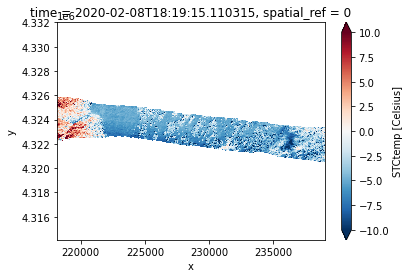

In [4]:
ds.STCtemp.plot(cmap='RdBu_r', vmin=-10, vmax=10)

---

**Point timeseries to help ground truth the airborne ir data**

To provide a source of "ground truth" for the airborne and satellite thermal infrared images during the SnowEx 2020 Grand Mesa IOP, we can use ground-based snow surface temperature measurements. On February 5, 2020, we installed a thermal infrared radiometer pointing at the snow surface at snow pit #2S10 (left), and buried temperature sensors beneath the snow surface (right). These logged observations at 5-minute intervals until we removed the instrumentation a week later on February 12.

<img src="snowpit_2s10.png" width="600"/>

What are the differences we might expect to see between the ground point and the thermal IR data?
 - our ground based radiometer was looking at 45 deg off nadir, versus nadir ASTER versus variable view angle airborne (snow emissivity changes off-nadir)
 - band-width of the radiometer versus the airborne camera versus ASTER and spectral response functions
 - atmospheric path length (from < 1 meter, to 1 km, to whole atmosphere) (wind-blown snow aloft?)
 - "point" (actually some weighted value of a small ellipse on the ground) versus pixels of different sizes, their own point spread functions, and geolocation accuracy
 
 ---

In [5]:
import pandas as pd

The data file doesn't include the column names, so we need to set the column headers following the dataset's README file.

In [6]:
column_headers = ['table', 'year', 'doy', 'time', # year, day of year, time of day (local time, UTC-7)
                  'rad_avg', 'rad_max', 'rad_min', 'rad_std', # radiometer surface temperature
                  'sb_avg', 'sb_max', 'sb_min', 'sb_std', # radiometer sensor body temperature (for calibration)
                  'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std', # temperature at 5 cm below snow surface
                  'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std', #               10 cm
                  'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std', #               15 cm
                  'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std', #               20 cm
                  'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std', #               30 cm
                  'batt_a','batt_b', # battery voltage data
                 ]

Open the file as a pandas data frame with read_csv

In [7]:
df = pd.read_csv('data/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/CR10X_GM1_final_storage_1.dat',
                 header = None, names = column_headers)

We need to do some formatting of the data fields, but we can preview what we just loaded fist

In [8]:
df.head() # show the first 5 rows of the dataframe

,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt_a,batt_b
0,101,2020,30,1537,22.963,22.963,22.963,0.000,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,22.96,22.83
1,101,2020,30,1538,22.962,22.963,22.961,0.001,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,22.96,22.83
2,101,2020,30,1539,25.080,26.810,22.968,1.484,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,24.47,22.83
3,101,2020,30,1540,25.320,25.569,25.133,0.184,22.839,22.846,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,25.42,22.85
4,102,2020,30,1540,12.050,0.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data cleanup and formatting

In [9]:
# Create a zero-padded time string (e.g. for 9:30 AM we are changing '930' into '0930')
df['time_str'] = [('0' * (4 - len(str(df.time[i])))) + str(df.time[i]) for i in range(df.shape[0])]
# change midnight from '2400' to '0000'
df.time_str.replace('2400', '0000', inplace=True)

Convert year and day of year to pandas datetime index:

In [10]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    '''Compose a datetime object from various datetime components. This clever solusion is from:
        https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas'''
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [11]:
# Create a datetime value from the date field and zero-padded time_str field, set this as our dataframe's index
df.index = compose_date(df['year'], 
                        days=df['doy'], 
                        hours=df['time_str'].str[:2],
                        minutes=df['time_str'].str[2:])

# Remove entries that are from table "102" (this contains datalogger battery information we're not interested in at the moment)
df = df[df.table != 102]

# drop the columns we no longer need
df.drop(columns=['table','year','doy','time','time_str','batt_a','batt_b'], inplace=True)

Inspect the contents

In [12]:
df.head()

,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,sb_min,sb_std,temp1_avg,temp1_max,...,temp3_min,temp3_std,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std
2020-01-30 15:37:00,22.963,22.963,22.963,0.000,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:38:00,22.962,22.963,22.961,0.001,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:39:00,25.080,26.810,22.968,1.484,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:40:00,25.320,25.569,25.133,0.184,22.839,22.846,22.832,0.005,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:41:00,24.894,25.069,24.611,0.182,22.860,22.860,22.860,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0


Make a simple plot

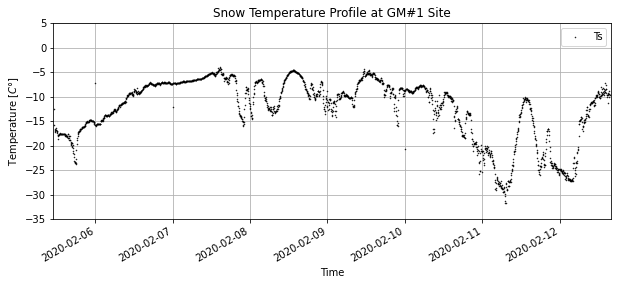

In [13]:
plt.figure(figsize=(10,4))

#df.temp1_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.8,0.8,1], label='-5 cm')
#df.temp2_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.6,0.6,1], label='-10 cm')
#df.temp3_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.4,0.4,1], label='-15 cm')
#df.temp4_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.2,0.2,1], label='-20 cm')
#df.temp5_avg.plot(linestyle='none', marker='.', markersize=1, c=[0,0,1], label='-30 cm')
df.rad_avg.plot(linestyle='none', marker='.', markersize=1, c='k', label='Ts')
plt.ylim((-35,5))
plt.xlim((pd.Timestamp(2020,2,5,11,0),pd.Timestamp(2020,2,12,16,0)))
plt.legend()
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')
plt.grid('on')
plt.title('Snow Temperature Profile at GM#1 Site');

But then we want to focus on the date/time when our IR image was from, so zoom in there (data slice or something)
Zoom in on Feb 8th

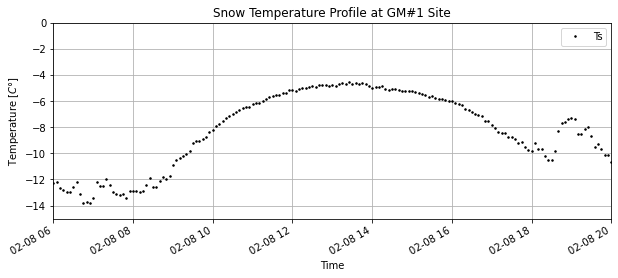

In [14]:
plt.figure(figsize=(10,4))

#df.temp1_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.8,0.8,1], label='-5 cm')
#df.temp2_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.6,0.6,1], label='-10 cm')
#df.temp3_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.4,0.4,1], label='-15 cm')
#df.temp4_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.2,0.2,1], label='-20 cm')
#df.temp5_avg.plot(linestyle='none', marker='.', markersize=1, c=[0,0,1], label='-30 cm')
df.rad_avg.plot(linestyle='none', marker='.', markersize=3, c='k', label='Ts')
plt.ylim((-15,0))
plt.xlim((pd.Timestamp(2020,2,8,6,0),pd.Timestamp(2020,2,8,20,0)))
plt.legend()
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')
plt.grid('on')
plt.title('Snow Temperature Profile at GM#1 Site');

And we want to look at where the data on the ground was in these images (plot point on image)

Grab temperature from airborne image, add to timeseries plot, plot side by side

---
We don't always have airplanes with IR, like i said we have satllites that can get us images more often

- lower spatial resolution just because they're further away
- mixed pixel problem, mixing different temperatures and blurring stuff together
- We timed this airborne imagery with ASTER at the same time

Load an ASTER geotiff, inspect the contents

In [15]:
ds = xr.open_rasterio('data/AST_L1T_00302082020180748_20200209065849_17218_ImageData14_wgs84.tif').squeeze()

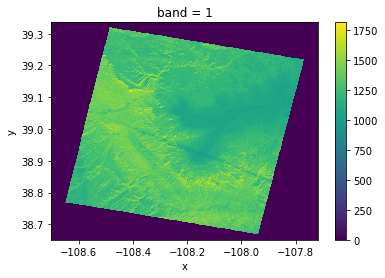

In [16]:
ds.plot()

https://lpdaac.usgs.gov/products/ast_l1tv003/



Show that we can find the following information in the ASTER product documentation:
- which bands/wavelengths we're looking at
  - Band 14: 10.95-11.65 μm
- how to convert from DN to Radiance
- how to convert from Radiance to Tb


Add screenshot/figures

In [17]:
def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

Convert from DN to radiance, radiance to brightness temperature (assume and emissivity of 1 for all surfaces, note that the airborne imagery also assumed emissivity of 1)

In [18]:
aster_band14_tb_c = tir_rad2tb( tir_dn2rad( ds, 14 ), 14 ) - 273.15

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


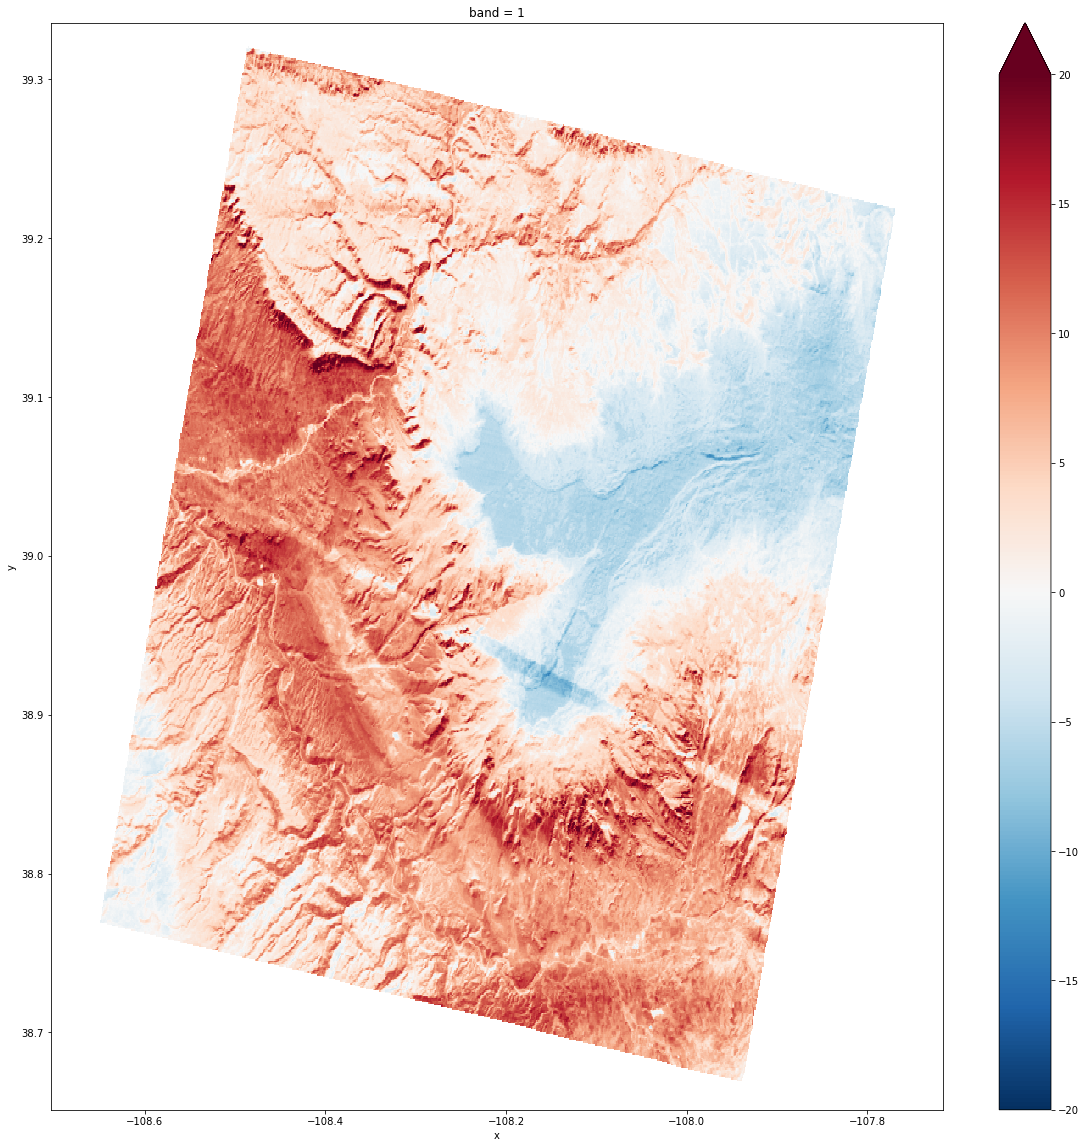

In [19]:
plt.figure(figsize=(20,20))
aster_band14_tb_c.plot(cmap='RdBu_r',vmin=-20,vmax=20)

Plot ASTER next to Airborne vis and IR to show scale differences



Grab temperature of ASTER pixel at point and add to timeseries plot

---
---
### **BONUS NOTEBOOKS**?
- Data access/download through EarthdataAPI if you want to explore that